In [1]:
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
import os
import sys
import matplotlib.pyplot as plt
from collections import deque
import random
import seaborn as sns
sns.set()
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
df = pd.read_csv('dataset/GOOG.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-08-12,242.212219,247.622620,241.496490,246.251251,246.251251,4404700
1,2010-08-13,244.744751,245.840836,243.248245,243.418411,243.418411,3865500
2,2010-08-16,242.082077,245.180176,240.490494,243.038040,243.038040,2607300
3,2010-08-17,244.509506,247.597595,243.258255,245.505508,245.505508,3777600
4,2010-08-18,245.465469,245.680679,241.016022,241.316315,241.316315,5367400


In [5]:
class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 500
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.Y = tf.placeholder(tf.float32, (None, self.state_size))
        self.ACTION = tf.placeholder(tf.float32, (None))
        self.REWARD = tf.placeholder(tf.float32, (None))
        self.batch_size = tf.shape(self.ACTION)[0]
        
        with tf.variable_scope('curiosity_model'):
            action = tf.reshape(self.ACTION, (-1,1))
            state_action = tf.concat([self.X, action], axis=1)
            save_state = tf.identity(self.Y)
            
            feed = tf.layers.dense(state_action, 32, activation=tf.nn.relu)
            self.curiosity_logits = tf.layers.dense(feed, self.state_size)
            self.curiosity_cost = tf.reduce_sum(tf.square(save_state - self.curiosity_logits), axis=1)
            
            self.curiosity_optimizer = tf.train.RMSPropOptimizer(self.LEARNING_RATE)\
            .minimize(tf.reduce_mean(self.curiosity_cost))
        
        total_reward = tf.add(self.curiosity_cost, self.REWARD)
        
        with tf.variable_scope("q_model"):
            with tf.variable_scope("eval_net"):
                x_action = tf.layers.dense(self.X, 128, tf.nn.relu)
                self.logits = tf.layers.dense(x_action, self.OUTPUT_SIZE)
            
            with tf.variable_scope("target_net"):
                y_action = tf.layers.dense(self.Y, 128, tf.nn.relu)
                y_q = tf.layers.dense(y_action, self.OUTPUT_SIZE)
            
            q_target = total_reward + self.GAMMA * tf.reduce_max(y_q, axis=1)
            action = tf.cast(self.ACTION, tf.int32)
            action_indices = tf.stack([tf.range(self.batch_size, dtype=tf.int32), action], axis=1)
            q = tf.gather_nd(params=self.logits, indices=action_indices)
            self.cost = tf.losses.mean_squared_error(labels=q_target, predictions=q)
            self.optimizer = tf.train.RMSPropOptimizer(self.LEARNING_RATE).minimize(
            self.cost, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "q_model/eval_net"))
            
        t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_model/target_net')
        e_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_model/eval_net')
        self.target_replace_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]
        
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def _memorize(self, state, action, reward, new_state, done):
        self.MEMORIES.append((state, action, reward, new_state, done))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()
            
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state])
        return action
    
    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        actions = np.array([a[1] for a in replay])
        rewards = np.array([a[2] for a in replay])
        new_states = np.array([a[3] for a in replay])
        if (self.T_COPY + 1) % self.COPY == 0:
            self.sess.run(self.target_replace_op)
            
        cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict = {
            self.X: states, self.Y: new_states, self.ACTION: actions, self.REWARD: rewards
        })
        
        if (self.T_COPY + 1) % self.COPY == 0:
            self.sess.run(self.curiosity_optimizer, feed_dict = {
                self.X: states, self.Y: new_states, self.ACTION: actions, self.REWARD: rewards
            })
        return cost
    
    def buy(self, initial_money,date1,close):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(close) - 1, self.skip):
            action = self._select_action(state)
            next_state = self.get_state(t + 1)
            
            
            
            if action == 1 and initial_money >= close[t]:
                inventory.append(close[t])
                initial_money -= close[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, close[t], initial_money))
                df1 = pd.DataFrame({'Date': date1[t+1], 'Close': [close[t+1]], 'RESULT': ['Buy']})
                if not os.path.isfile('output/18.curiosity-q-learning-agent.csv'):
                    df1.to_csv('output/18.curiosity-q-learning-agent.csv', index=False)
                else:
                    df1.to_csv('output/18.curiosity-q-learning-agent.csv', index=False, mode='a', header=False)
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += close[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
                df2 = pd.DataFrame({'Date': date1[t+1], 'Close': [close[t+1]], 'RESULT': ['Sell']})
                if not os.path.isfile('output/18.curiosity-q-learning-agent.csv'):
                    df2.to_csv('output/18.curiosity-q-learning-agent.csv', index=False)
                else:
                    df2.to_csv('output/18.curiosity-q-learning-agent.csv', index=False, mode='a', header=False)
            else:
                print(
                    'day %d, hold UNIT at price %f,  total balance %f,'
                    % (t+1, close[t+1], initial_money)
                )
                df3 = pd.DataFrame({'Date': date1[t+1], 'Close': [close[t+1]], 'RESULT': ['Hold']})
                if not os.path.isfile('output/18.curiosity-q-learning-agent.csv'):
                    df3.to_csv('output/18.curiosity-q-learning-agent.csv', index=False)
                else:
                    df3.to_csv('output/18.curiosity-q-learning-agent.csv', index=False, mode='a', header=False)
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        print(
                '\ntotal gained %f, total investment %f %%'
                % (initial_money - starting_money, invest)
            )
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                
                action = self._select_action(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                
                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                state = next_state
                replay = random.sample(self.MEMORIES, batch_size)
                cost = self._construct_memories(replay)
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [6]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 1, checkpoint = 1, initial_money = initial_money)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [7]:
date = df.Date.values.tolist()
agent.buy(initial_money = initial_money,date1=date,close=close)

day 1: buy 1 unit at price 243.418411, total balance 9756.581589
day 2: buy 1 unit at price 243.038040, total balance 9513.543549
day 3: buy 1 unit at price 245.505508, total balance 9268.038041
day 5: buy 1 unit at price 234.219223, total balance 9033.818818
day 6: buy 1 unit at price 231.241241, total balance 8802.577577
day 7, sell 1 unit at price 232.267273, investment -4.581058 %, total balance 9034.844850,
day 8, sell 1 unit at price 225.920914, investment -7.042982 %, total balance 9260.765764,
day 9, sell 1 unit at price 227.537537, investment -7.318765 %, total balance 9488.303301,
day 11: buy 1 unit at price 229.644638, total balance 9258.658663
day 13, sell 1 unit at price 225.235229, investment -3.835720 %, total balance 9483.893892,
day 14: buy 1 unit at price 230.395401, total balance 9253.498491
day 15, sell 1 unit at price 231.821823, investment 0.251072 %, total balance 9485.320314,
day 16, sell 1 unit at price 235.385391, investment 2.499842 %, total balance 9720.7057

day 1145, sell 1 unit at price 578.789978, investment -1.696737 %, total balance 2648.141036,
day 1146, sell 1 unit at price 578.330017, investment -2.521526 %, total balance 3226.471053,
day 1147: buy 1 unit at price 581.429993, total balance 2645.041060
day 1148: buy 1 unit at price 572.900024, total balance 2072.141036
day 1149: buy 1 unit at price 574.099976, total balance 1498.041060
day 1152: buy 1 unit at price 561.169983, total balance 936.871077
day 1154: buy 1 unit at price 561.640015, total balance 375.231062
day 1155, sell 1 unit at price 557.609985, investment -7.893961 %, total balance 932.841047,
day 1157, sell 1 unit at price 563.669983, investment -5.625602 %, total balance 1496.511030,
day 1162: buy 1 unit at price 563.640015, total balance 932.871015
day 1164: buy 1 unit at price 561.140015, total balance 371.731000
day 1168, sell 1 unit at price 543.950012, investment -7.555950 %, total balance 915.681012,
day 1169: buy 1 unit at price 544.859985, total balance 370.

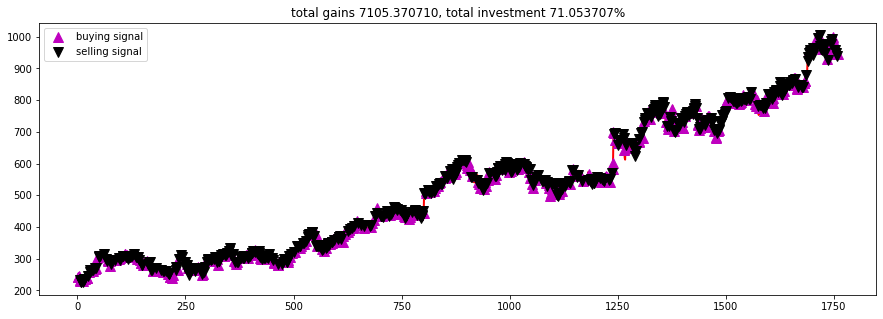

In [8]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()